In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.utils import plot_model



ModuleNotFoundError: No module named 'numpy'

In [2]:
def jacard_coef(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0)/(K.sum(y_true_f)+K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [28]:
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

# Load the model
unetmodel = tf.keras.models.load_model("UNET_BASE_MAXEPOCHS.h5", custom_objects={
                   'jacard_coef': jacard_coef})

attenresmodel = tf.keras.models.load_model("Attention_resunet.h5", custom_objects={
                   'jacard_coef': jacard_coef})

# Define image path
image_path = 'input_test.png'  # Update this to your image path

# Load and preprocess the image
image = imread(image_path)[:,:,:3]  # Ensure the image is in RGB
image = resize(image, (128, 128), mode='constant', preserve_range=True)
image_resized = np.expand_dims(image, axis=0)  # Expand dims to fit model input

# Perform prediction
Unetprediction = unetmodel.predict(image_resized)
attenresprediction = attenresmodel.predict(image_resized)





/var/folders/mh/v3x6dz8534gcdj91_hh0bdph0000gn/T/ipykernel_90411/940315988.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


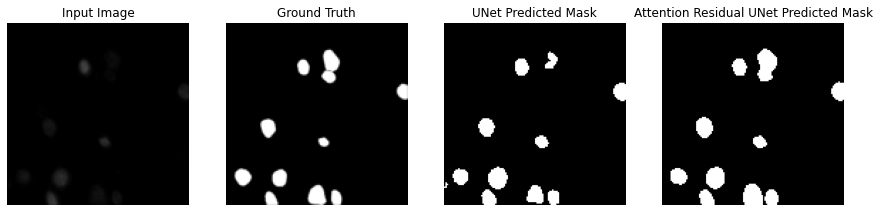

In [35]:
from script import connectedComponents
BATCH_SIZE = 16 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for mask_file in next(os.walk("masks"))[2]:
    if mask_file != ".DS_Store":
        mask_ = imread('masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        
# Set up matplotlib figures
fig, axs = plt.subplots(1, 4, figsize=(15, 7))

# Display the input image
axs[0].imshow(image.astype(np.uint8))
axs[0].title.set_text('Input Image')

axs[1].imshow(np.squeeze(mask), cmap='gray')
axs[1].title.set_text('Ground Truth')

# Convert the prediction to binary mask if needed
binary_prediction = (Unetprediction[0] > 0.9).astype(np.uint8)
D2 = np.squeeze(binary_prediction)
nuclei_count, adjusted_nuclei_count = connectedComponents(D2)
l, r = min(nuclei_count, adjusted_nuclei_count), max(
    nuclei_count, adjusted_nuclei_count)
axs[2].imshow(D2, cmap='gray')
axs[2].title.set_text(f'UNet Predicted Mask - Nuclei Count = {l} - {r}')

binary_prediction = (attenresprediction[0] > 0.9).astype(np.uint8)
D2 = np.squeeze(binary_prediction)
nuclei_count, adjusted_nuclei_count = connectedComponents(D2)
l, r = min(nuclei_count, adjusted_nuclei_count), max(
    nuclei_count, adjusted_nuclei_count)
axs[3].imshow(np.squeeze(binary_prediction), cmap='gray')
axs[3].title.set_text(f'Attention Residual UNet Predicted Mask - Nuclei Count = {l} - {r}')

# Remove axes for a cleaner look
for ax in axs:
    ax.axis('off')

plt.show()